# Exploring the taxonomy of the mock community

In [1]:
#workDir = '/home/nick/notebook/fullCyc/data/MiSeq_16S/515f-806r/V4_Lib1-5/ordination/explore/'

biomFile = 'data/otu_table_515SIP_wtax.biom'
metadataFile = 'data/Metadata_515806_Density.txt'
treeFile = 'data/otusn_515SIP.tree'

mockCommDir = '/home/nick/notebook/fullCyc/data/MiSeq_16S/Hay-lab_mock_community/'

# Init

In [2]:
%load_ext rpy2.ipython

In [3]:
%%R
library(phyloseq)
library(ggplot2)
library(gridExtra)
library(dplyr)
library(tidyr)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘dplyr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [4]:
%%R -i biomFile -i metadataFile -i treeFile

## biom file
physeq = import_biom(biomFile, treeFile)

## loading sample metadata
sample.data = import_qiime_sample_data(metadataFile)
physeq = merge_phyloseq(physeq,sample.data)

print(physeq)

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 18671 taxa and 637 samples ]
sample_data() Sample Data:       [ 637 samples by 16 sample variables ]
tax_table()   Taxonomy Table:    [ 18671 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 18671 tips and 18670 internal nodes ]


In [5]:
%%R 
sparcity.thresh = 0.25

# filtering/normalizing
physeq.snorm = transform_sample_counts(physeq, function(x) x/sum(x))
physeq.thresh = filter_taxa(physeq.snorm, function(x) sum(x > 0) > (sparcity.thresh * length(x)), TRUE)
print(physeq.thresh)

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3077 taxa and 637 samples ]
sample_data() Sample Data:       [ 637 samples by 16 sample variables ]
tax_table()   Taxonomy Table:    [ 3077 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 3077 tips and 3076 internal nodes ]


## Filtering to just mock community samples

In [9]:
%%R
physeq.thresh.m = physeq.thresh %>% sample_data %>% as.matrix %>% as.data.frame
physeq.thresh.mock = prune_samples(physeq.thresh.m$Treatment == 'Mock', physeq.thresh)
physeq.thresh.mock = filter_taxa(physeq.thresh.mock, function(x) sum(x) > 0, TRUE)
physeq.thresh.mock

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 69 taxa and 2 samples ]
sample_data() Sample Data:       [ 2 samples by 16 sample variables ]
tax_table()   Taxonomy Table:    [ 69 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 69 tips and 68 internal nodes ]


## Number of taxa per sample

In [10]:
%%R
tbl.otu = physeq.thresh.mock %>% otu_table %>% as.data.frame
tbl.otu$otu = rownames(tbl.otu)

tbl.otu = tbl.otu %>%
    gather('sample', 'abundance', 1:(ncol(tbl.otu)-1)) %>%
    group_by(otu) %>%
    mutate(median_abund = median(abundance),
           total_abund = sum(abundance))

tbl.otu %>% head(n=4)

Source: local data frame [4 x 5]
Groups: otu [4]

        otu               sample    abundance median_abund  total_abund
      (chr)               (fctr)        (dbl)        (dbl)        (dbl)
1   OTU.124 Mock.community.Pool4 0.0000417432 0.0000208716 0.0000417432
2  OTU.1663 Mock.community.Pool4 0.0000000000 0.0000242436 0.0000484872
3 OTU.16143 Mock.community.Pool4 0.0000000000 0.0000242436 0.0000484872
4     OTU.1 Mock.community.Pool4 0.0005844047 0.0004861512 0.0009723023


In [17]:
%%R

tmp = physeq.thresh.m %>% select(Full.sample,Pool)

tbl.otu.j = inner_join(tbl.otu, tmp, c('sample' = 'Full.sample'))
tbl.otu.j %>% head

Source: local data frame [6 x 6]
Groups: otu [6]

        otu               sample    abundance median_abund  total_abund   Pool
      (chr)                (chr)        (dbl)        (dbl)        (dbl) (fctr)
1   OTU.124 Mock.community.Pool4 0.0000417432 0.0000208716 0.0000417432      4
2  OTU.1663 Mock.community.Pool4 0.0000000000 0.0000242436 0.0000484872      4
3 OTU.16143 Mock.community.Pool4 0.0000000000 0.0000242436 0.0000484872      4
4     OTU.1 Mock.community.Pool4 0.0005844047 0.0004861512 0.0009723023      4
5 OTU.13577 Mock.community.Pool4 0.0002504592 0.0004161528 0.0008323056      4
6  OTU.9415 Mock.community.Pool4 0.0102270830 0.0113926338 0.0227852676      4


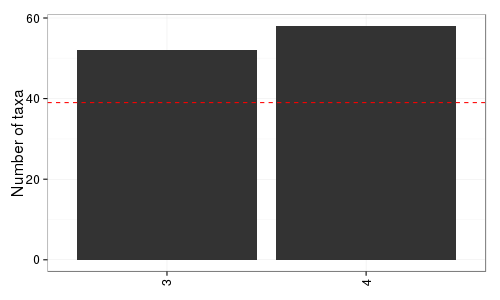

In [22]:
%%R -w 500 -h 300

# number of strains in Hay-lab mock community summary
n.taxa.in.mock = 39  

tbl.otu.s = tbl.otu.j %>%
    #mutate(sample = gsub('_F.+', '', sample)) %>%
    filter(abundance > 0) %>%
    group_by(Pool) %>%
    summarize(n_taxa = n())

ggplot(tbl.otu.s, aes(Pool, n_taxa)) +
    geom_bar(stat='identity') +
    geom_hline(yintercept=n.taxa.in.mock, linetype='dashed', color='red') +
    labs(y='Number of taxa') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=90, vjust=0.5),
        axis.title.x = element_blank()
        )

#### Notes

* Red line = number of taxa in Hay-lab mock community summary table
* The number of taxa in each mock community is fairly similar to the 'real' community

### Filtered to just abundant taxa

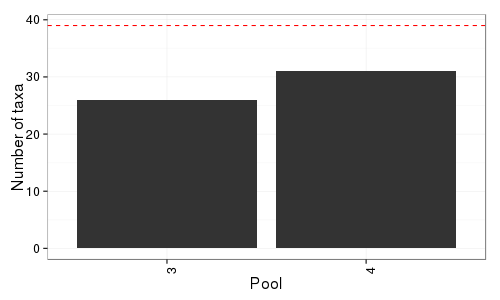

In [23]:
%%R -w 500 -h 300

tbl.otu.s = tbl.otu.j %>%
#    mutate(sample = gsub('_F.+', '', sample)) %>%
    filter(abundance > 0.0001) %>%
    group_by(Pool) %>%
    summarize(n_taxa = n())

ggplot(tbl.otu.s, aes(Pool, n_taxa)) +
    geom_bar(stat='identity') +
    geom_hline(yintercept=n.taxa.in.mock, linetype='dashed', color='red') +
    labs(y='Number of taxa') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=90)
        )

#### Notes:

* Very similar numbers of taxa to 'true' community if filtering out taxa that are < 0.01% of the community abundance

### Abundance distribution of each taxon

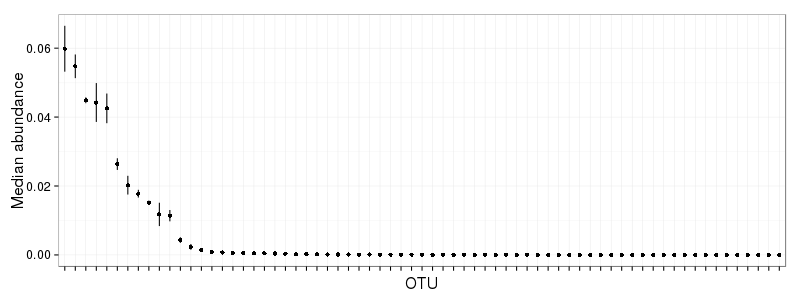

In [24]:
%%R -w 800 -h 300

tbl.otu.s = tbl.otu.j %>%
    group_by(otu) %>%
    summarize(median_abund = median(abundance),
              sd_abund = sd(abundance, na.rm=TRUE),
              n = n())


tbl.otu.s$otu = reorder(tbl.otu.s$otu, -tbl.otu.s$median_abund)

ggplot(tbl.otu.s, aes(otu, median_abund, 
                      ymin=median_abund - sd_abund,
                      ymax=median_abund + sd_abund)) +
    geom_pointrange() +
    labs(x='OTU', y='Median abundance') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_blank()
        )

### Just the most abundant OTUs

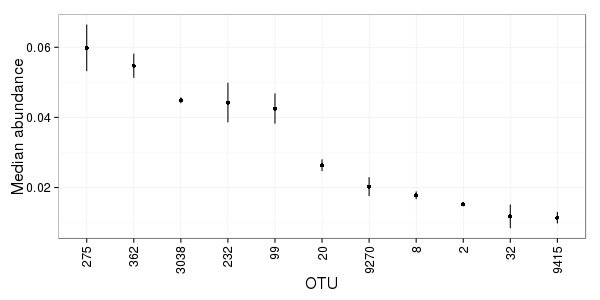

In [25]:
%%R -w 600 -h 300

tbl.otu.s = tbl.otu.j %>%
    group_by(otu) %>%
    summarize(median_abund = median(abundance),
              sd_abund = sd(abundance)) %>%
    ungroup() %>%
    filter(median_abund > 0.01) %>%
    mutate(otu = gsub('OTU\\.', '', otu))


tbl.otu.s$otu = reorder(tbl.otu.s$otu, -tbl.otu.s$median_abund)

ggplot(tbl.otu.s, aes(otu, median_abund, 
                      ymin=median_abund - sd_abund,
                      ymax=median_abund + sd_abund)) +
    geom_pointrange() +
    labs(x='OTU', y='Median abundance') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=90, hjust=1, vjust=0.5)
        )

# Assessing taxonomic composition

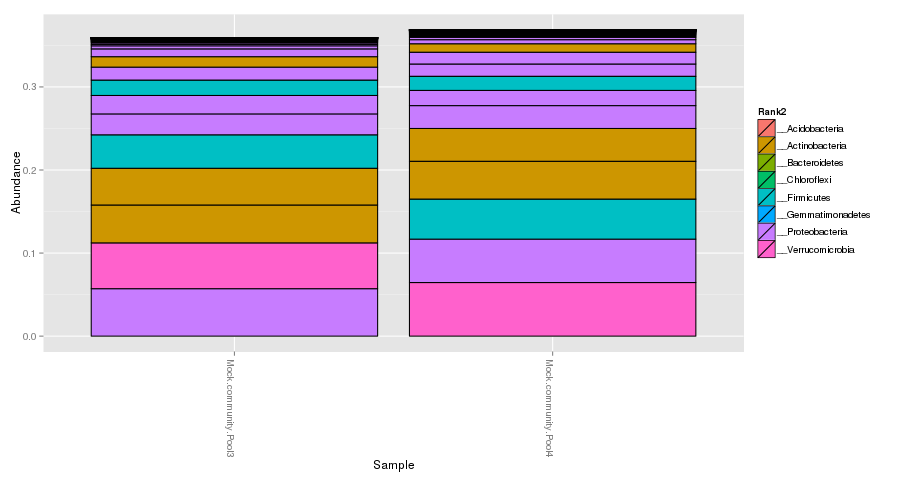

In [26]:
%%R -w 900

plot_bar(physeq.thresh.mock, fill='Rank2')

In [56]:
%%R
# tbl.otu = physeq.thresh.mock %>% otu_table %>% as.data.frame
# tbl.otu$otu = rownames(tbl.otu)

# tbl.otu = tbl.otu %>%
#     gather('sample', 'abundance', 1:(ncol(tbl.otu)-1)) %>%
#     group_by(otu) %>%
#     mutate(total_abund = sum(abundance))

# tbl.otu %>% head

NULL


In [27]:
%%R

tbl.tax = physeq.thresh.mock %>% tax_table %>% as.data.frame
tbl.tax$otu = rownames(tbl.tax)
tbl.tax %>% head(n=3)

             Rank1              Rank2                            Rank3
OTU.124   Bacteria    __Acidobacteria __Candidatus_Chloracidobacterium
OTU.1663  Bacteria      __Chloroflexi                 __Thermomicrobia
OTU.16143 Bacteria __Gemmatimonadetes               __Gemmatimonadales
                                         Rank4                  Rank5 Rank6
OTU.124   __uncultured_Acidobacteria_bacterium                   <NA>  <NA>
OTU.1663                        __JG30-KF-CM45 __uncultured_bacterium  <NA>
OTU.16143                  __Gemmatimonadaceae           __uncultured  <NA>
          Rank7 Rank8       otu
OTU.124    <NA>  <NA>   OTU.124
OTU.1663   <NA>  <NA>  OTU.1663
OTU.16143  <NA>  <NA> OTU.16143


In [28]:
%%R
tbl.j = inner_join(tbl.otu.j, tbl.tax, c('otu' = 'otu')) %>%
        ungroup %>%
        mutate(otu = gsub('OTU\\.', '', otu),
               Rank2 = gsub('^__', '', Rank2),
               Rank3 = gsub('^__', '', Rank3))
    
tbl.j %>% head(n=3)

Source: local data frame [3 x 14]

    otu               sample   abundance median_abund total_abund   Pool
  (chr)                (chr)       (dbl)        (dbl)       (dbl) (fctr)
1   124 Mock.community.Pool4 4.17432e-05  2.08716e-05 4.17432e-05      4
2  1663 Mock.community.Pool4 0.00000e+00  2.42436e-05 4.84872e-05      4
3 16143 Mock.community.Pool4 0.00000e+00  2.42436e-05 4.84872e-05      4
Variables not shown: Rank1 (fctr), Rank2 (chr), Rank3 (chr), Rank4 (fctr),
  Rank5 (fctr), Rank6 (fctr), Rank7 (fctr), Rank8 (fctr)


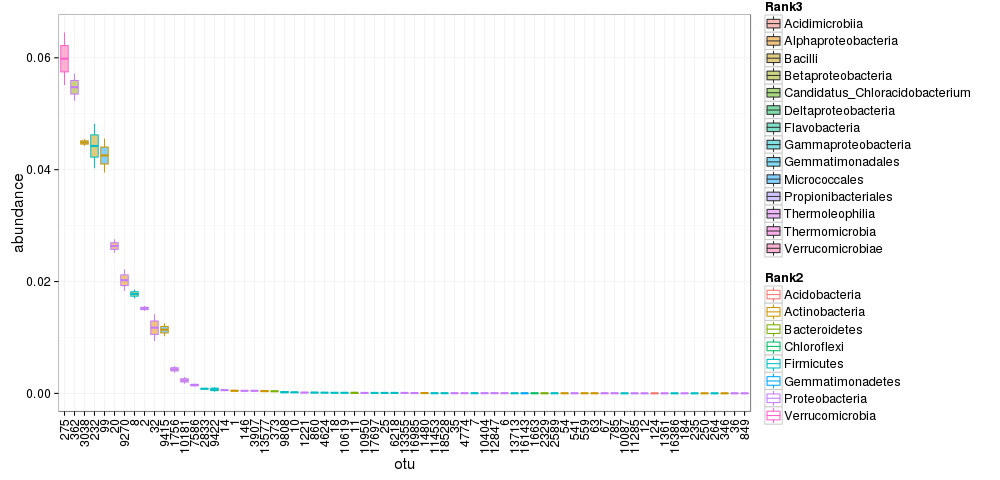

In [29]:
%%R -w 1000 

tbl.j$otu = reorder(tbl.j$otu, -tbl.j$total_abund)

ggplot(tbl.j, aes(otu, abundance, color=Rank2, fill=Rank3)) +
    geom_boxplot(alpha=0.5) +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=90, vjust=0.5, hjust=1)
        )

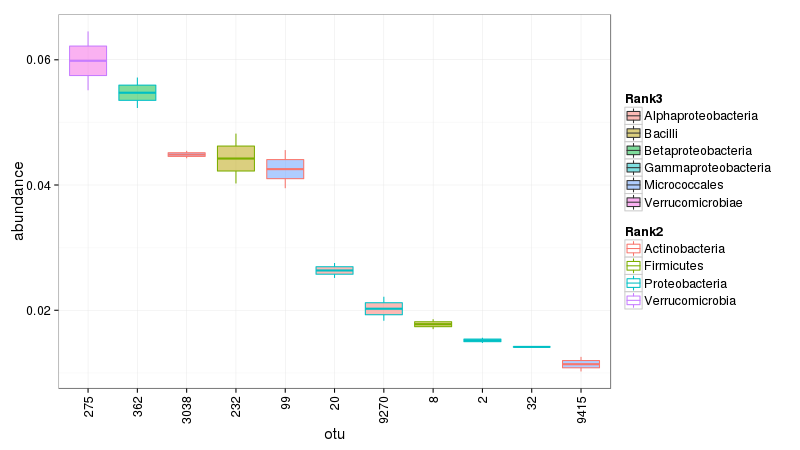

In [30]:
%%R -w 800 -h 450
tbl.j.f = tbl.j %>%
    filter(abundance >= 0.01)

ggplot(tbl.j.f, aes(otu, abundance, color=Rank2, fill=Rank3)) +
    geom_boxplot(alpha=0.5) +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=90, vjust=0.5, hjust=1)
        )

In [31]:
%%R -w 800 -h 300

tbl.j.s = tbl.j %>%
    group_by(otu, Rank2, Rank3, Rank4, Rank5, Rank6, Rank7) %>%
    summarize(median_abund = median(abundance),
              sd_abund = sd(abundance, na.rm=TRUE),
              n = n())

tbl.j.s %>% head

Source: local data frame [6 x 10]
Groups: otu, Rank2, Rank3, Rank4, Rank5, Rank6 [6]

     otu           Rank2               Rank3                Rank4
  (fctr)           (chr)               (chr)               (fctr)
1    275 Verrucomicrobia    Verrucomicrobiae __Verrucomicrobiales
2    362  Proteobacteria  Betaproteobacteria    __Burkholderiales
3   3038  Actinobacteria       Micrococcales     __Micrococcaceae
4    232      Firmicutes             Bacilli         __Bacillales
5     99  Actinobacteria       Micrococcales     __Micrococcaceae
6     20  Proteobacteria Alphaproteobacteria        __Rhizobiales
Variables not shown: Rank5 (fctr), Rank6 (fctr), Rank7 (fctr), median_abund
  (dbl), sd_abund (dbl), n (int)


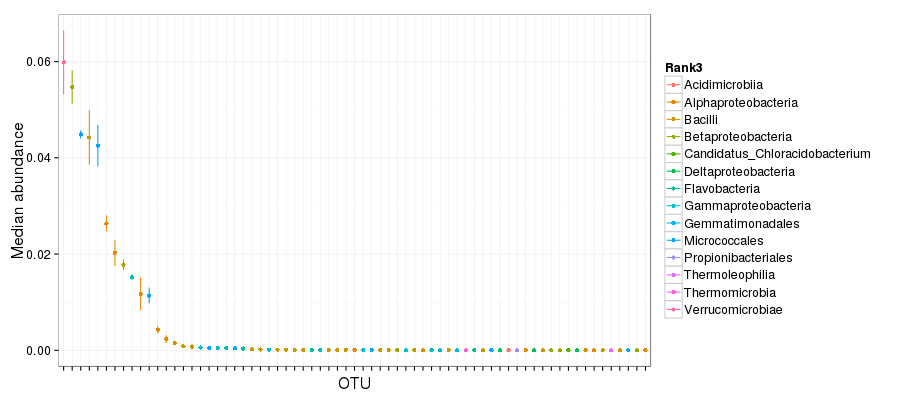

In [32]:
%%R -w 900 -h 400

tbl.j.s$otu = reorder(tbl.j.s$otu, -tbl.j.s$median_abund)

ggplot(tbl.j.s, aes(otu, median_abund, 
                      ymin=median_abund - sd_abund,
                      ymax=median_abund + sd_abund)) +
    geom_pointrange(aes(color=Rank3)) +
    labs(x='OTU', y='Median abundance') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_blank()
        )

### Just most abundant taxa

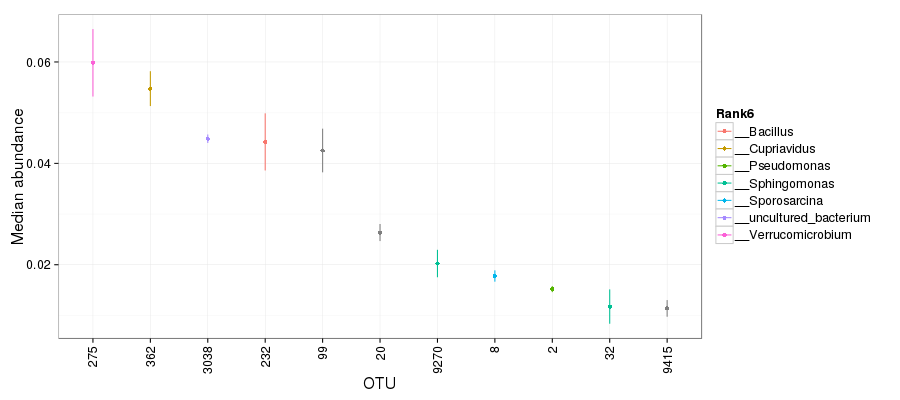

In [33]:
%%R -w 900 -h 400

tbl.j.s$otu = reorder(tbl.j.s$otu, -tbl.j.s$median_abund)

tbl.j.s.f = tbl.j.s %>%
    filter(median_abund >= 0.01)

ggplot(tbl.j.s.f, aes(otu, median_abund, 
                      ymin=median_abund - sd_abund,
                      ymax=median_abund + sd_abund)) +
    geom_pointrange(aes(color=Rank6)) +
    labs(x='OTU', y='Median abundance') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=90, vjust=0.5, hjust=1)
        )

# Comparing mock community OTU composition to table of 'true' mock community composition

## Loading 'true' mock community composition: phylum level

In [34]:
%%R -i mockCommDir
setwd(mockCommDir)

mock.known = read.delim('strain_taxonomy.txt', sep='\t')

mock.known = mock.known$phylum %>% table %>% as.data.frame
colnames(mock.known) = c('phylum', 'freq.known')

mock.known = mock.known %>%
    group_by() %>%
    mutate(freq.known.norm = freq.known / sum(freq.known),
           sd.freq.known.norm = 0,
           se.freq.known.norm = 0)

mock.known %>% head

Source: local data frame [5 x 5]

          phylum freq.known freq.known.norm sd.freq.known.norm
          (fctr)      (int)           (dbl)              (dbl)
1 Actinobacteria          4      0.10526316                  0
2  Bacteroidetes          2      0.05263158                  0
3     Firmicutes          8      0.21052632                  0
4 Proteobacteria         23      0.60526316                  0
5   Spirochaetes          1      0.02631579                  0
Variables not shown: se.freq.known.norm (dbl)


## Comparing relative compositions of phylum

In [36]:
%%R
mock.est = tbl.j %>%
    filter(abundance > 0) %>%
    group_by(Pool, Rank2) %>%
    summarize(n=n()) %>%
    group_by(Pool) %>%
    mutate(freq.est.norm = n / sum(n)) %>%
    group_by(Rank2) %>%
    summarize(mean.freq.est.norm = mean(freq.est.norm),
              sd.freq.est.norm = sd(freq.est.norm), 
              se.freq.est.norm = sd(freq.est.norm) / sqrt(length(freq.est.norm))) %>%
    ungroup %>%
    rename('phylum' = Rank2) 
    
mock.est %>% head(n=3)

Source: local data frame [3 x 4]

          phylum mean.freq.est.norm sd.freq.est.norm se.freq.est.norm
           (chr)              (dbl)            (dbl)            (dbl)
1  Acidobacteria         0.01724138               NA               NA
2 Actinobacteria         0.14588859       0.01125369       0.00795756
3  Bacteroidetes         0.04608753       0.01641163       0.01160477


In [37]:
%%R

mock.j = left_join(mock.est, mock.known, c('phylum' = 'phylum')) %>%
    gather('mean.freq.cat', 'mean.freq.value', mean.freq.est.norm, freq.known.norm) %>%
    mutate(se.freq.est.norm = ifelse(mean.freq.cat == 'freq.known.norm', NA, se.freq.est.norm))
mock.j %>% as.data.frame %>% tail(n=4)

             phylum sd.freq.est.norm se.freq.est.norm freq.known
13       Firmicutes     0.0009378074               NA          8
14 Gemmatimonadetes               NA               NA         NA
15   Proteobacteria     0.0450147553               NA         23
16  Verrucomicrobia     0.0014067111               NA         NA
   sd.freq.known.norm se.freq.known.norm   mean.freq.cat mean.freq.value
13                  0                  0 freq.known.norm       0.2105263
14                 NA                 NA freq.known.norm              NA
15                  0                  0 freq.known.norm       0.6052632
16                 NA                 NA freq.known.norm              NA


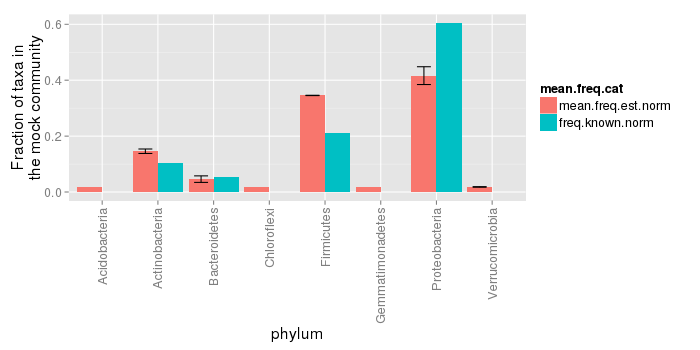

In [38]:
%%R -w 700 -h 350

ggplot(mock.j, aes(phylum, mean.freq.value, fill=mean.freq.cat)) +
    geom_bar(stat='identity', position='dodge') +
    geom_errorbar(aes(ymin = mean.freq.value - se.freq.est.norm,
                      ymax = mean.freq.value + se.freq.est.norm,
                      group=mean.freq.cat), position=position_dodge(0.9), width=0.5) +
    labs(y='Fraction of taxa in\nthe mock community') +
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=90, vjust=0.5, hjust=1)
        )

#### Notes:

* freq.est = taxonomy from sequence data
* freq.known = taxonomy from Hay lab mock community summary table
* The numbers are fairly consistent for the 4 most used phyla in the mock community


### Filtering out low abundance taxa

In [39]:
%%R 
# mock communities from sequence data

tmp = tbl.j %>% 
    filter(abundance > 0.01) %>%
    mutate(Rank2 = gsub('^__', '', Rank2)) %>%
    group_by(otu, Rank2) %>%
    summarize(n=n()) %>%
    ungroup() %>%
    select(Rank2) 

mock.est = tmp$Rank2 %>% table %>% as.data.frame
colnames(mock.est) = c('phylum', 'freq.est')

mock.est = mock.est %>%
    group_by() %>%
    mutate(freq.est.norm = freq.est / sum(freq.est))

mock.est %>% head

Source: local data frame [4 x 3]

           phylum freq.est freq.est.norm
           (fctr)    (int)         (dbl)
1  Actinobacteria        3    0.27272727
2      Firmicutes        2    0.18181818
3  Proteobacteria        5    0.45454545
4 Verrucomicrobia        1    0.09090909


In [40]:
%%R

mock.j = left_join(mock.est, mock.known, c('phylum' = 'phylum')) %>%
    gather('variable', 'value', freq.est.norm, freq.known.norm)

mock.j %>% head

Source: local data frame [6 x 7]

           phylum freq.est freq.known sd.freq.known.norm se.freq.known.norm
            (chr)    (int)      (int)              (dbl)              (dbl)
1  Actinobacteria        3          4                  0                  0
2      Firmicutes        2          8                  0                  0
3  Proteobacteria        5         23                  0                  0
4 Verrucomicrobia        1         NA                 NA                 NA
5  Actinobacteria        3          4                  0                  0
6      Firmicutes        2          8                  0                  0
Variables not shown: variable (fctr), value (dbl)


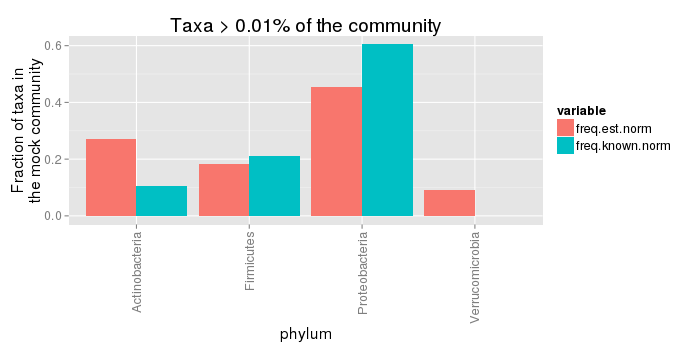

In [41]:
%%R -w 700 -h 350

ggplot(mock.j, aes(phylum, value, fill=variable)) +
    geom_bar(stat='identity', position='dodge') +
    labs(y='Fraction of taxa in\nthe mock community', title='Taxa > 0.01% of the community') +
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=90, vjust=0.5, hjust=1)
        )

## Comparing relative compositions of genera

In [42]:
%%R -i mockCommDir
setwd(mockCommDir)

mock.known = read.delim('strain_taxonomy.txt', sep='\t')

mock.known = mock.known$genus %>% table %>% as.data.frame
colnames(mock.known) = c('genus', 'freq.known')

mock.known = mock.known %>%
    group_by() %>%
    mutate(freq.known.norm = freq.known / sum(freq.known))

mock.known %>% head

Source: local data frame [6 x 3]

          genus freq.known freq.known.norm
         (fctr)      (int)           (dbl)
1 Achromobacter          1      0.02631579
2 Agrobacterium          1      0.02631579
3   Alcaligenes          2      0.05263158
4  Arthrobacter          1      0.02631579
5      Bacillus          2      0.05263158
6  Enterobacter          1      0.02631579


In [43]:
%%R 
# mock communities from sequence data

tmp = tbl.j %>% 
    mutate(Rank6 = gsub('^__', '', Rank6), 
           Rank6 = gsub('uncultured_', '', Rank6)) %>%
    group_by(otu, Rank6) %>%
    summarize(n=n()) %>%
    ungroup() %>%
    select(Rank6) 

mock.est = tmp$Rank6 %>% table %>% as.data.frame
colnames(mock.est) = c('genus', 'freq.est')

mock.est = mock.est %>%
    group_by() %>%
    mutate(freq.est.norm = freq.est / sum(freq.est))

mock.est %>% head

Source: local data frame [6 x 3]

        genus freq.est freq.est.norm
       (fctr)    (int)         (dbl)
1    Azoarcus        1    0.01785714
2    Bacillus       14    0.25000000
3   bacterium        5    0.08928571
4 Blastomonas        1    0.01785714
5  Cellvibrio        1    0.01785714
6 Cupriavidus        1    0.01785714


In [44]:
%%R

mock.j = left_join(mock.est, mock.known, c('genus' = 'genus')) %>%
    gather('variable', 'value', freq.est.norm, freq.known.norm) %>%
    group_by(variable)

mock.j %>% head

Source: local data frame [6 x 5]
Groups: variable [1]

        genus freq.est freq.known      variable      value
        (chr)    (int)      (int)        (fctr)      (dbl)
1    Azoarcus        1         NA freq.est.norm 0.01785714
2    Bacillus       14          2 freq.est.norm 0.25000000
3   bacterium        5         NA freq.est.norm 0.08928571
4 Blastomonas        1         NA freq.est.norm 0.01785714
5  Cellvibrio        1         NA freq.est.norm 0.01785714
6 Cupriavidus        1         NA freq.est.norm 0.01785714


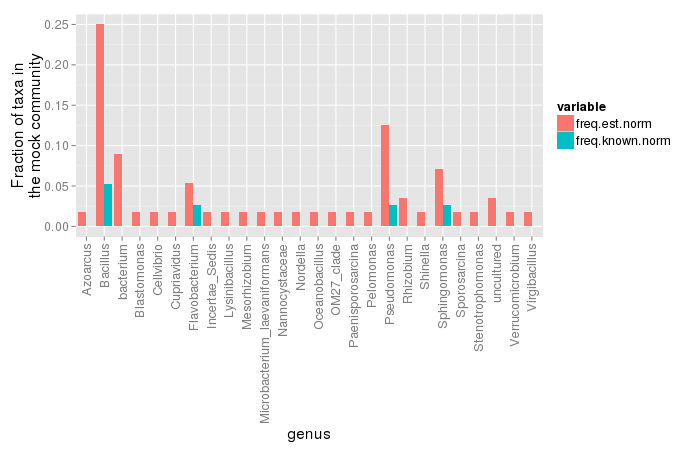

In [45]:
%%R -w 700 -h 450

ggplot(mock.j, aes(genus, value, fill=variable)) +
    geom_bar(stat='identity', position='dodge') +
    labs(y='Fraction of taxa in\nthe mock community') +
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=90, vjust=0.5, hjust=1)
        )

# Conclusions

* The number of OTUs in the sequenced mock is pretty similar to the actual number of taxa in the community
  * w/in 2 fold
  * This is especially true if all taxa that are `<0.01%` of the community are removed
* The community composition between sequenced and true communities is:
  * Similar at the phylum level
  * Not too accurate at the genus level